In [1]:
# add path
import sys
sys.path.append('../Deliverable_2/')
sys.path.append('../Deliverable_3/')

import pandas as pd 
import numpy as np
import itertools
import seaborn as sns

# import utils functions and classes
from DataLoader import TADataLoader
from TextPreprocessing import TextPreprocessor, split_reviews_per_sentence
from ReviewPreprocessing import review_preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow_addons.metrics import F1Score

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

# import data augmentation
from DataAugmenter import DataAugmenter

# import tensorflow functions
import tensorflow as tf

from TrainingDataGenerator import generate_training_data
from EmbeddorSkipgram import Skipgram
from HierarchicalAttentionModel import HierarchicalAttentionNetwork
from HAN_optimal import HierarchicalAttentionNetwork_Opt
from plot_utils import PlotAttentionWeights

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julienbernardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[===-----------------------------------------------] 7.3% 27.4/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 15.5% 58.4/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============------------------------------------] 29.5% 111.0/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================--------------------------------] 37.7% 141.6/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================--------------------------] 49.1% 184.7/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================----------------------] 57.0% 214.5/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.4% 246.0/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 83.7% 314.8/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================================-----] 91.8% 345.3/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 376.1/376.1MB downloaded


In [3]:
import tqdm
tqdm.tqdm_notebook()
tqdm.notebook.tqdm().pandas()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Load scrapped data

In [4]:
loader = TADataLoader(data_file='scrapped_data_balanced.jl')
df_reviews = loader.load_reviews(drop_duplicates=True)

In [5]:
preprocessor = TextPreprocessor(df_reviews, column_to_clean='review_content')
preprocessor.transform(n_grams=False)
corpus = preprocessor.corpus

In [6]:
print('The initial size of the corpus is %.f.' % len(corpus))

The initial size of the corpus is 69175.


# Data augmentation

The original data we have collected is hihgly imbalanced. We can clearly see that the majority of reviews have a rating 5. 

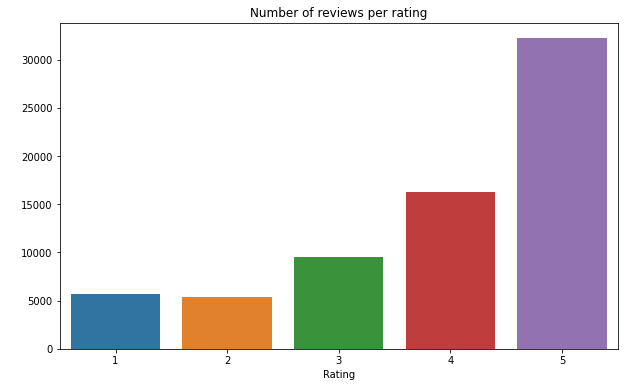

In [7]:
sns.countplot(x='review_rating', data=df_reviews)
plt.title('Number of reviews per rating')
plt.xlabel('Rating')
plt.ylabel(' ')
plt.show()

We proceeded to augment the data with lower representation in our dataset. We did so by substituting some of the words from these reviews by the closest similar word. In order to find these close words, we used a pre-trained word2vec model. 

In [8]:
augmenter = DataAugmenter([1, 2])
augmenter.augment()
augmented_df = augmenter.merge(df_reviews[['review_content', 'review_rating']])

The following reviews have been augmented: 1 2


After the data augmentation, we see that the classes are more evenly distributed, but there is still a prevalence of reviews rated 5. We proceed, therefore, to downsample these reviews. 

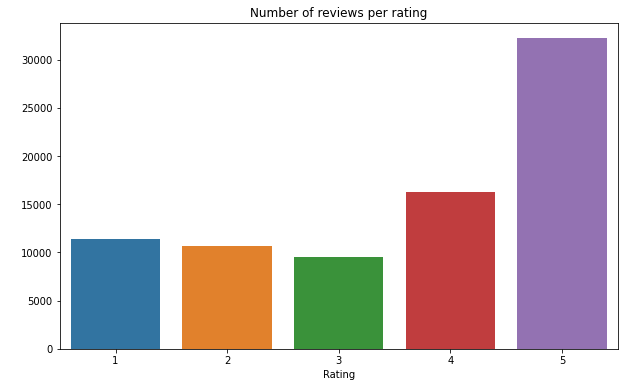

In [9]:
sns.countplot(x='review_rating', data=augmented_df)
plt.title('Number of reviews per rating')
plt.xlabel('Rating')
plt.ylabel(' ')
plt.show()

In [10]:
# downsampling 5s

five_reviews = augmented_df.loc[augmented_df['review_rating']==5]
five_sample = five_reviews.sample(int(len(five_reviews)/2))

# delete all fives from original df
filtered_reviews = augmented_df.loc[augmented_df['review_rating']!=5]
train_data = pd.concat([five_sample, filtered_reviews])

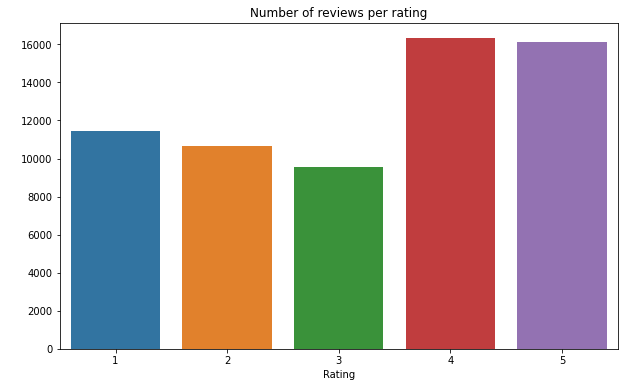

In [11]:
sns.countplot(x='review_rating', data=train_data)
plt.title('Number of reviews per rating')
plt.xlabel('Rating')
plt.ylabel(' ')
plt.show()

In [12]:
print(f'The training dataset has: {len(train_data)} reviews')

The training dataset has: 64094 reviews


# Classification

In [13]:
train_data = split_reviews_per_sentence(train_data)

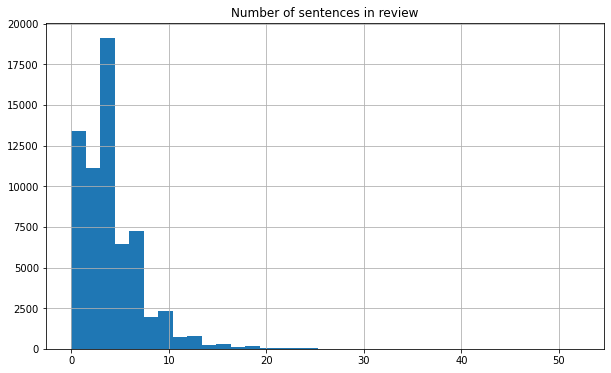

In [14]:
# Visualize number of sentences per review
train_data["review_sentences"].apply(len).hist(bins=35)
plt.title('Number of sentences in review')
plt.show()

### Get pretrained embedding weights

In [15]:
sentences = list(itertools.chain(*train_data["review_sentences"]))
print(f"Number of total sentences : {len(sentences)}")

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' ', char_level=False)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences) 

print(f"Number of total words : {max(tokenizer.index_word.keys())}")

Number of total sentences : 252533
Number of total words : 84568


In [16]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2, 
    num_ns=4, 
    vocab_size=max(tokenizer.index_word.keys())+1 
)

BATCH_SIZE = 1024
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [17]:
embedding_dim = 128

word2vec = Skipgram(vocab_size=max(tokenizer.index_word.keys())+1, embedding_dim=128)
word2vec.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [18]:
word2vec.fit(dataset, epochs=20)

Epoch 1/20
2298/2298 [==============================] - 285s 124ms/step - loss: 1.3807 - accuracy: 0.4315
Epoch 2/20
2298/2298 [==============================] - 281s 122ms/step - loss: 1.0945 - accuracy: 0.5888
Epoch 3/20
2298/2298 [==============================] - 281s 122ms/step - loss: 0.9147 - accuracy: 0.6630
Epoch 4/20
2298/2298 [==============================] - 281s 122ms/step - loss: 0.7830 - accuracy: 0.7133
Epoch 5/20
2298/2298 [==============================] - 280s 122ms/step - loss: 0.6838 - accuracy: 0.7504
Epoch 6/20
2298/2298 [==============================] - 281s 122ms/step - loss: 0.6079 - accuracy: 0.7794
Epoch 7/20
2298/2298 [==============================] - 282s 123ms/step - loss: 0.5490 - accuracy: 0.8019
Epoch 8/20
2298/2298 [==============================] - 281s 122ms/step - loss: 0.5028 - accuracy: 0.8193
Epoch 9/20
2298/2298 [==============================] - 269s 117ms/step - loss: 0.4660 - accuracy: 0.8326
Epoch 10/20
2298/2298 [=======================

In [19]:
pretrained_weights = word2vec.get_layer('w2v_embedding').get_weights()[0]

### Predict review ratings 

In [20]:
train_data['usable_rating'] = train_data['review_rating'].apply(lambda r: int(r)-1)
rating_labels = tf.keras.utils.to_categorical(train_data['usable_rating'], num_classes=5, dtype='float32')

In [21]:
padded_preprocessed_reviews = [review_preprocessing(review, tokenizer) for review in tqdm.notebook.tqdm(train_data["review_sentences"])]
padded_preprocessed_reviews = tf.stack(padded_preprocessed_reviews)
padded_preprocessed_reviews.shape

TensorShape([64094, 10, 50])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(padded_preprocessed_reviews.numpy(), rating_labels, test_size=0.3)

# build tensorflow formatted datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

### Model selection

We summarize below the results obtained on a validation set for all hyperparameter combinations that have been tested.

In [ ]:
# Base GRU + tanh: val_accuracy: 0.5782
# Downsample 5s + LSTM + ReLu: val_accuracy: 0.5617
# Downsample 5s + GRU + ReLu + dropout 20%: val_accuracy: 0.5578
# Downsample 5s + LSTM + tanh + dropout 20%: val_accuracy: 0.5656
# Downsample 5s + LSTM + tanh: val_accuracy: 0.5654

# Macro F1 score
# Downsample 5s + LSTM + tanh: val_f1_score: 0.5077
# Downsample 5s + GRU + tanh: val_f1_score: 0.4802
# Downsample 5s + LSTM + tanh + dropout 20% after Attention layer: val_f1_score: 0.5084
# Downsample 5s + LSTM + tanh + dropout 20% before Attention layer: val_f1_score: 0.4972
# Downsample 5s + LSTM + relu + dropout 20% after Attention layer: val_f1_score: 0.5041
# Downsample 5s + LSTM + selu + dropout 20% after Attention layer: val_f1_score: 0.4690
# Downsample 5s + LSTM + relu + dropout 20% in LSTM layers: val_f1_score: 0.5360
# Downsample 5s + LSTM + tanh + dropout 20% in LSTM layers: val_f1_score: 0.5340
# Downsample 5s + LSTM + relu + regularize(activity, bias, kernel l1=l2=0.02) + dropout 20% in LSTM layers: val_f1_score: 0.5247
# Downsample 5s + LSTM + relu + regularize(Dense kernel l2=0.001) + dropout 20% in LSTM layers: val_f1_score: 0.5210
# Downsample 5s + LSTM + relu + regularize(LSTM kernel l2=0.001) + dropout 20% in LSTM layers: val_f1_score: 0.5063
# Downsample 5s + LSTM + relu + regularize(LSTM kernel l2=0.001) + dropout 20% in LSTM layers + lr=0.005: val_f1_score: 0.4537
# Downsample 5s + LSTM + relu + regularize(Dense kernel l2=0.01) + dropout 20% in LSTM layers + lr=0.002: val_f1_score: 0.5281
# Downsample 5s + LSTM + relu + dropout 20% in LSTM layers + lr=0.002: val_f1_score: 0.5295
# Downsample 5s + LSTM + relu + dropout 30% in LSTM layers + lr=0.001: val_f1_score: 0.5376
# Downsample 5s + LSTM + relu + dropout 40% in LSTM layers + lr=0.001: val_f1_score: 0.5168
# Downsample 5s + LSTM + relu + dropout 40% in LSTM layers + lr=0.003: val_f1_score: 0.5196
# Downsample 5s + LSTM + relu + dropout 30% in LSTM layers + lr=0.001 + code correction: val_f1_score: 0.4904
# Downsample 5s + LSTM + relu + dropout 30% in LSTM layers + lr=0.005 + code correction: val_f1_score: 0.5429 
# Downsample 5s + LSTM + relu + dropout 30% in LSTM layers + lr=0.003 + code correction: val_f1_score: 0.5299
# Downsample 5s + LSTM + relu + dropout 30% in LSTM layers + lr=0.004 + code correction: val_f1_score: 0.5350
# Downsample 5s + LSTM + relu + regularize(Dense kernel l2=0.01) + dropout 30% in LSTM layers + lr=0.005 + code correction: val_f1_score: 0.5297

# Final model
# Downsample 5s + LSTM + relu + dropout 30% in LSTM layers + lr=0.005 + code correction: val_f1_score: 0.5470, val_accuracy: 0.5994

In [27]:
# initialize Base HAN model
han_model_base = HierarchicalAttentionNetwork(
    vocab_size=max(tokenizer.index_word.keys())+1, 
    embedding_dim=128, 
    pretrained_weights=pretrained_weights, 
    gru_units=32, 
    attention_units=32, 
    classifier_units=5
)

f1 = F1Score(5,'macro')
es = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=3)

han_model_base.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[f1, 'accuracy']
)

In [28]:
han_history_base = han_model_base.fit(
    train_ds, 
    epochs=20, 
    validation_data=test_ds,
    callbacks=[es],
)

Epoch 1/20
44/44 [==============================] - 96s 2s/step - loss: 1.5365 - f1_score: 0.2101 - accuracy: 0.2931 - val_loss: 1.4303 - val_f1_score: 0.2937 - val_accuracy: 0.3692
Epoch 2/20
44/44 [==============================] - 91s 2s/step - loss: 1.2724 - f1_score: 0.3998 - accuracy: 0.4460 - val_loss: 1.1096 - val_f1_score: 0.4904 - val_accuracy: 0.5235
Epoch 3/20
44/44 [==============================] - 95s 2s/step - loss: 0.9998 - f1_score: 0.5362 - accuracy: 0.5658 - val_loss: 0.9718 - val_f1_score: 0.5518 - val_accuracy: 0.5763
Epoch 4/20
44/44 [==============================] - 95s 2s/step - loss: 0.8820 - f1_score: 0.5944 - accuracy: 0.6191 - val_loss: 0.9419 - val_f1_score: 0.5706 - val_accuracy: 0.5916
Epoch 5/20
44/44 [==============================] - 95s 2s/step - loss: 0.8032 - f1_score: 0.6394 - accuracy: 0.6598 - val_loss: 0.9365 - val_f1_score: 0.5722 - val_accuracy: 0.5960
Epoch 6/20
44/44 [==============================] - 95s 2s/step - loss: 0.7215 - f1_score:

In [36]:
# initialize Optimal HAN model
han_model_opt = HierarchicalAttentionNetwork_Opt(
    vocab_size=max(tokenizer.index_word.keys())+1, 
    embedding_dim=128, 
    pretrained_weights=pretrained_weights, 
    gru_units=32, 
    attention_units=32, 
    classifier_units=5
)

han_model_opt.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[f1, 'accuracy']
)

In [38]:
han_history_opt = han_model_opt.fit(
    train_ds, 
    epochs=30, 
    validation_data=test_ds,
    callbacks=[es],
)

Epoch 1/30
44/44 [==============================] - 115s 3s/step - loss: 1.4028 - f1_score: 0.3501 - accuracy: 0.3502 - val_loss: 1.0934 - val_f1_score: 0.4284 - val_accuracy: 0.4876
Epoch 2/30
44/44 [==============================] - 107s 2s/step - loss: 1.0075 - f1_score: 0.5078 - accuracy: 0.5387 - val_loss: 0.9537 - val_f1_score: 0.5518 - val_accuracy: 0.5786
Epoch 3/30
44/44 [==============================] - 108s 2s/step - loss: 0.8230 - f1_score: 0.6183 - accuracy: 0.6406 - val_loss: 0.9321 - val_f1_score: 0.5824 - val_accuracy: 0.5986
Epoch 4/30
44/44 [==============================] - 108s 2s/step - loss: 0.6620 - f1_score: 0.7097 - accuracy: 0.7255 - val_loss: 0.9952 - val_f1_score: 0.5874 - val_accuracy: 0.6063
Epoch 5/30
44/44 [==============================] - 109s 2s/step - loss: 0.5309 - f1_score: 0.7769 - accuracy: 0.7875 - val_loss: 1.1312 - val_f1_score: 0.5868 - val_accuracy: 0.6013
Epoch 6/30
44/44 [==============================] - 105s 2s/step - loss: 0.3999 - f1_

<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

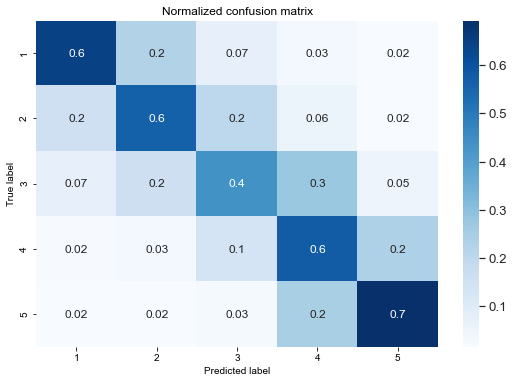

In [41]:
# Confusion Matrix for Base HAN
y_predict_base = han_model_base.predict(test_ds)
matrix_base = confusion_matrix(y_test.argmax(axis=1), y_predict_base.argmax(axis=1), normalize='true')

df_cm_base = pd.DataFrame(matrix_base, columns=[1, 2, 3, 4, 5], index=[1, 2, 3, 4, 5])

df_cm_base.index.name = 'True label'
df_cm_base.columns.name = 'Predicted label'
plt.figure(figsize = (9, 6))
plt.title('Normalized confusion matrix')
sns.set(font_scale=1.2) 
sns.heatmap(df_cm_base, cmap="Blues", annot=True, annot_kws={"size": 12}, fmt='.1g')


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

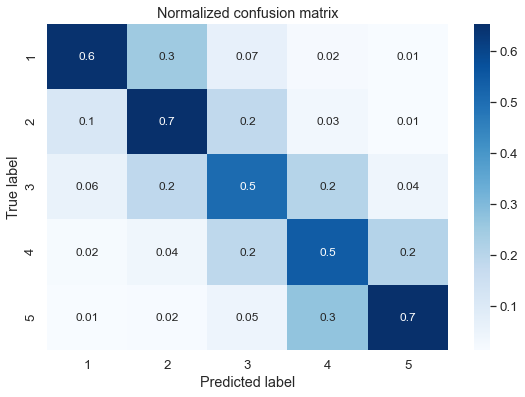

In [42]:
# Confusion Matrix for Optimal HAN
y_predict_opt = han_model_opt.predict(test_ds)
matrix_opt = confusion_matrix(y_test.argmax(axis=1), y_predict_opt.argmax(axis=1), normalize='true')

df_cm_opt = pd.DataFrame(matrix_opt, columns=[1, 2, 3, 4, 5], index=[1, 2, 3, 4, 5])

df_cm_opt.index.name = 'True label'
df_cm_opt.columns.name = 'Predicted label'
plt.figure(figsize = (9, 6))
plt.title('Normalized confusion matrix')
sns.set(font_scale=1.2) 
sns.heatmap(df_cm_opt, cmap="Blues", annot=True, annot_kws={"size": 12}, fmt='.1g')

### Evaluate models

# Bonus: Attention words and sentences

We see our model can correctly identify the most important words in the sentence. 

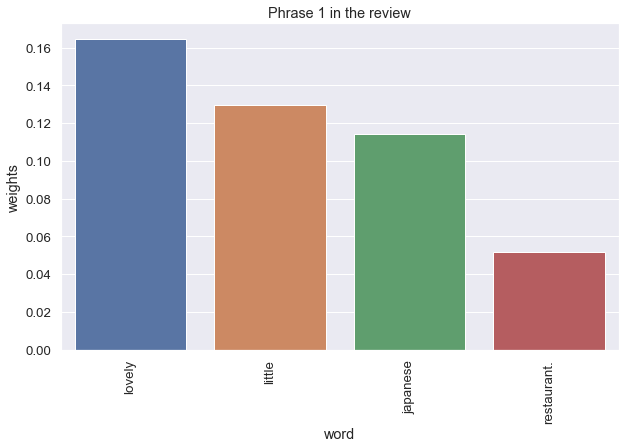

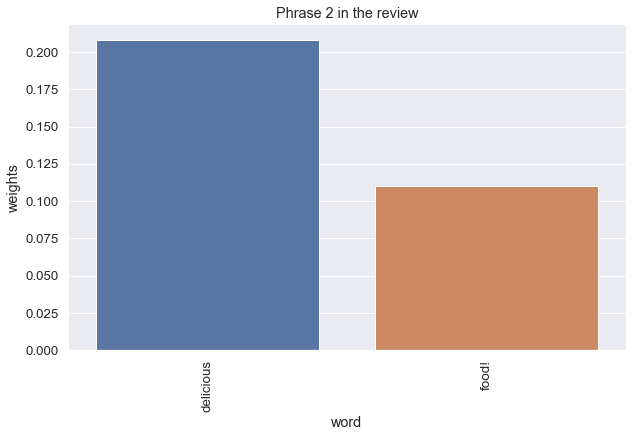

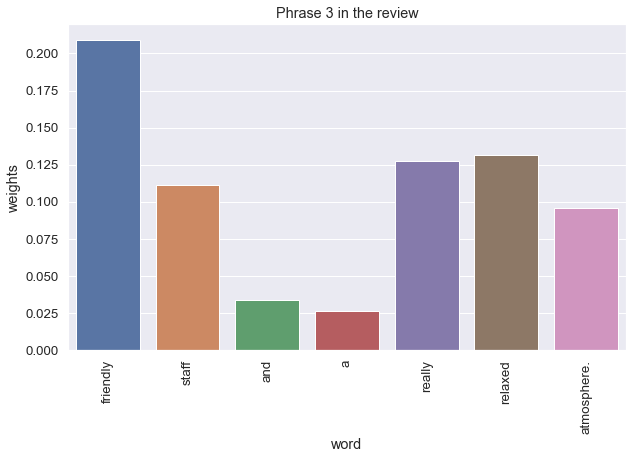

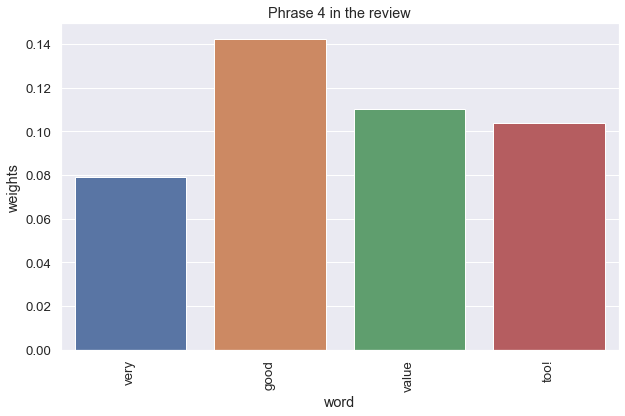

In [58]:
i=5
example = padded_preprocessed_reviews[i:i+1]
reverse_word_mapper = dict(map(reversed, tokenizer.word_index.items()))

plotter = PlotAttentionWeights(padded_preprocessed_reviews[i:i+1], han_model_opt, reverse_word_mapper)
plotter.plot_attention_weights_sentences()

However it does not behave as predicted in some cases. We hope that some further preprocessing could help with it. 

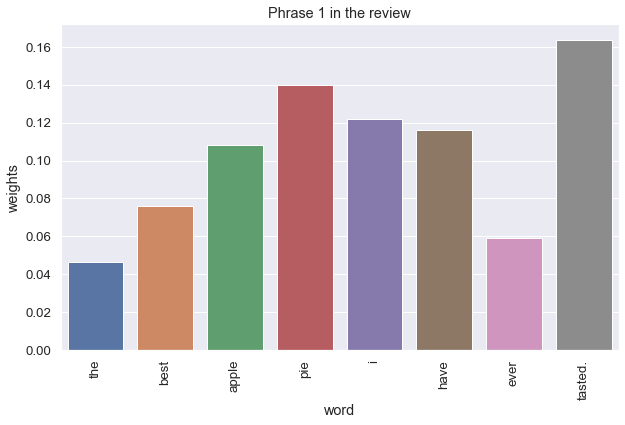

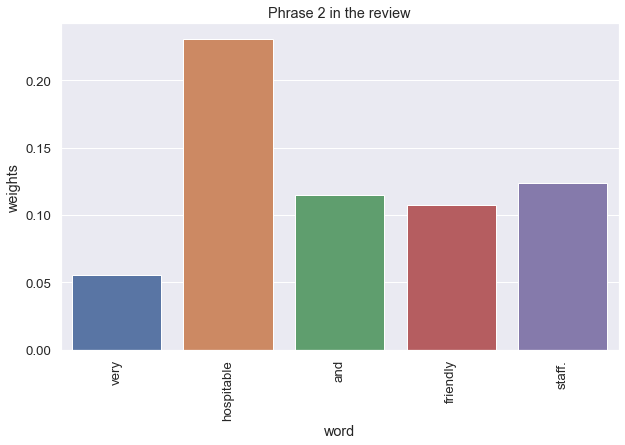

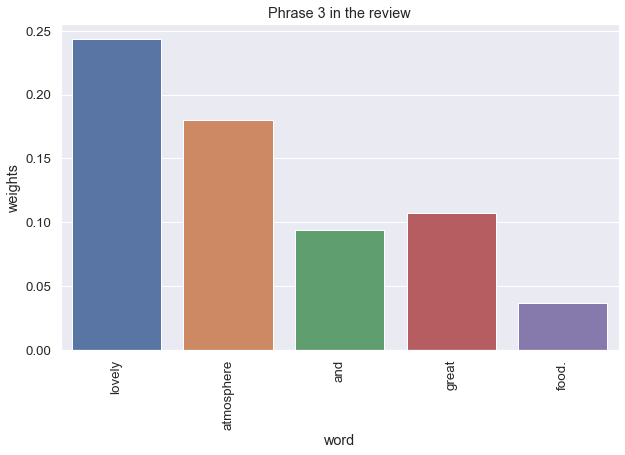

In [60]:
i=8
example = padded_preprocessed_reviews[i:i+1]
reverse_word_mapper = dict(map(reversed, tokenizer.word_index.items()))

plotter = PlotAttentionWeights(padded_preprocessed_reviews[i:i+1], han_model_opt, reverse_word_mapper)
plotter.plot_attention_weights_sentences()